In [2]:
from qdots_qll.models import game
import jax
from jax import jit, vmap
import numpy as np
import jax.numpy as jnp
import qdots_qll.all_funcs as all_f
import matplotlib.pyplot as plt
from functools import partial

In [3]:
model = game.physical_model()

In [4]:
true_pars = game.true_pars
bnds = jnp.array(
    [
        [0.01, 0.9],
        [0.01, 0.9],
        [0.001, 0.22],
        [-0.01, -0.9],
    ]
)

In [5]:
key = jax.random.PRNGKey(seed=0)

In [6]:
number_of_particles = 500

number_of_experimental_repetitions = 10

In [7]:
weights = all_f.initialize_weights(number_of_particles)

In [8]:
key, subkey = jax.random.split(key)
particles_locations = all_f.initialize_particle_locations(
    subkey, model.number_of_parameters, number_of_particles, bnds
)

cov_list = []
iter = 0

In [9]:
from functools import partial


@jit
def _iteration_smc(
    iteration,
    key,
    weights,
    particles_locations,
    model,
    true_pars,
    number_of_experimental_repetitions=10,
):
    key, subkey = jax.random.split(key)
    t = jax.random.uniform(key=subkey, minval=0.01, maxval=40)
    keys = jax.random.split(key, number_of_experimental_repetitions + 1)

    key = keys[0]

    results = jax.vmap(model.generate_data, in_axes=(0, None, None))(
        keys[1:], true_pars, t
    )

    all_lkls = jax.vmap(model.likelihood_particle, in_axes=(0, None))(
        particles_locations, t
    )

    lkl_results_all_particles = vmap(game.likelihood_data, in_axes=(0, None))(
        all_lkls, results
    )

    lkl = jnp.prod(lkl_results_all_particles, axis=1)

    weights = all_f.update_weights(lkl, weights)
    covariance = all_f.est_cov(particles_locations, weights)
    return iteration + 1, key, weights, particles_locations, covariance


# def _iteration_smc_partial_fori(a):
#     f = partial(
#         _iteration_smc,
#         model=model,
#         true_pars=true_pars,
#     )
#     return f(*a)

In [10]:
@jit
def _is_iter_lower_than_min_iter(iter, min_iterations):
    """Returns True if iter < min_iterations

    Args:
        iter (_type_): _description_
        min_iterations (_type_): _description_

    Returns:
        _type_: _description_
    """
    return jax.lax.cond(
        iter < min_iterations, lambda _: True, lambda _: False, None
    )


@jit
def _std_check_exit(array_of_cov_norms, threshold):
    """_summary_

    Args:
        array_of_cov_norms (_type_): Array with norms of covariance
        threshold (_type_): threshold

    Returns:
        _type_: Returns true if the standard deviation among norms is greater or equal than epsilon. False otherwise
    """

    pred = jnp.nanstd(array_of_cov_norms)

    return jax.lax.cond(
        (pred >= threshold),
        lambda _: True,
        lambda _: False,
        None,
    )


@jit
def _niter_check_exit(n_iter, max_iter):
    """_summary_

    Args:
        a (_type_): Array with norms of covariance
        threshold (_type_): threshold

    Returns:
        _type_: Returns true if the standard deviation among norms is greater or equal than epsilon. False otherwise
    """

    return jax.lax.cond(
        n_iter < max_iter, lambda _: True, lambda _: False, None
    )


# Main problem with this is that we cannot use this in while loop as we want to return value.
# I need a function that takes all the inputs, uses some of them to call this.
def _check_conditions_exit(run_object):
    # array_of_cov_norms, n_iter, threshold_cov_norm, max_iter
    """Returns True when execution should continue. Three conditions are checked:
    - True if n_iter (current iteration) is < than the minimum iteration to start checking things.
    - If n_iter > min_iter, returns True if n_iter is < max iterations
    - If std_norm_cov_array of last 10 iterations  > than the threshold to stop, return True.



    Args:
        array_of_cov_norms (_type_): _description_
        n_iter (_type_): _description_
        threshold_cov_norm (_type_): _description_
        max_iter (_type_): _description_

    Returns:
        _type_: _description_
    """

    # From the object we extract important information. The current iteration, the max iteration, the min_iteration
    # to start checking things and the threshold to stop.

    n_iter = run_object.iteration
    max_iter = run_object.max_iterations
    min_iterations = run_object.min_iterations
    threshold_cov_norm = run_object.std_threshold

    # We select the last 10 covariances matrices.
    full_cov_array = run_object.cov_array
    # cov_array = run_object.cov_array[-10 + n_iter : n_iter]

    lookback = 40

    cov_array = jax.lax.dynamic_slice(
        full_cov_array,
        [n_iter - lookback] + list(full_cov_array.shape[-2:]),
        [lookback] + list(full_cov_array.shape[-2:]),
    )

    # Compute the norm of these last covariances
    array_of_cov_norms = jax.vmap(jnp.linalg.norm, in_axes=(0))(cov_array)

    # We check the conditions regarding iter < max_iter and std of norm of covariance > threshold.

    iter_condition = _niter_check_exit(n_iter, max_iter)
    norm_std_condition = _std_check_exit(
        array_of_cov_norms, threshold_cov_norm
    )
    # This first checks that iteration< min_iteration. Returns true.
    # If false, check other conditions
    return jax.lax.cond(
        _is_iter_lower_than_min_iter(n_iter, min_iterations),
        lambda _: True,
        lambda a: jnp.logical_and(*a),
        jnp.array([iter_condition, norm_std_condition]),
    )

In [11]:
import equinox as eqx


class Run(eqx.Module):
    iteration: int
    key: jax.Array
    weights: jax.Array
    particles_locations: jax.Array
    max_iterations: int
    min_iterations: int
    std_threshold: float
    cov_array: jax.Array

    def __init__(
        self,
        iteration,
        key,
        weights,
        particles_locations,
        cov_array,
        max_iterations,
        min_iterations,
        std_threshold,
    ):
        self.iteration = iteration
        self.key = key
        self.weights = weights
        self.particles_locations = particles_locations
        self.cov_array = cov_array
        self.max_iterations = max_iterations
        self.min_iterations = min_iterations
        self.std_threshold = std_threshold

    def unwrap_updatable_elements(self):
        return [
            self.iteration,
            self.key,
            self.weights,
            self.particles_locations,
            # self.cov_array,
        ]

    def unwrap_non_updatable_elements(self):
        return [
            self.max_iterations,
            self.min_iterations,
            self.std_threshold,
            # self.cov_array,
        ]

In [12]:
all_f.resample_now?

Signature:      all_f.resample_now(key, particle_locations, weights, a=0.95)
Call signature: all_f.resample_now(*args, **kwargs)
Type:           PjitFunction
String form:    <PjitFunction of <function resample_now at 0x74e3f2091760>>
File:           ~/dev/qdots_efficient/qdots_qll/all_funcs.py

In [13]:
@partial(jax.jit, static_argnums=1)
def update_run_with_partial_func(run_object, partial_function_to_update):
    # update the weights
    updated_variables = partial_function_to_update(
        run_object.unwrap_updatable_elements()
    )

    (
        iteration,
        key,
        weights,
        particles_locations,
        covariance,
    ) = updated_variables

    key, particles_locations, weights = jax.lax.cond(
        all_f.ESS(weights) > weights.shape[0] / 2,
        lambda a: a,
        lambda a: all_f.resample_now(*a),
        (key, particles_locations, weights),
    )

    new_iter = updated_variables[
        0
    ]  # takes the number of iteration to set covariance in correct place

    old_cov = run_object.cov_array
    new_cov = old_cov.at[new_iter].set(
        updated_variables[4]
    )  # set of new covariance

    # create another instance of run object with the updated things
    return Run(
        *(updated_variables[:-1]),  # don't include the covariance vector
        new_cov,  # add the updated array with covariance
        *run_object.unwrap_non_updatable_elements()
    )


# example_update_cl(
#     example_update_cl(ecl, _iteration_smc_partial_fori),
#     _iteration_smc_partial_fori,
# ).cov_array

In [14]:
def _make_partial_update_smc_object(a, f):
    return f(*a)


def yokese(
    initial_run,
    func_update_smc,
    model,
    true_pars,
):
    # This is the partial function that sets the true parameters and the model
    # of the function that updates one smc step
    f_for_iteration_smc_partial = partial(
        func_update_smc, model=model, true_pars=true_pars
    )

    # The function
    _iteration_smc_partial = partial(
        _make_partial_update_smc_object, f=f_for_iteration_smc_partial
    )
    body_fun_for_while = jax.jit(
        partial(
            update_run_with_partial_func,
            partial_function_to_update=_iteration_smc_partial,
        )
    )
    return jax.lax.while_loop(
        _check_conditions_exit, body_fun_for_while, initial_run
    )

In [31]:
key, subkey = jax.random.split(key)


number_of_particles = 2000
init_weights = all_f.initialize_weights(number_of_particles)

init_particles_locations = all_f.initialize_particle_locations(
    subkey, model.number_of_parameters, number_of_particles, bnds
)


max_iterations = 3000
min_iterations = 100

initial_cov_array = jnp.zeros(
    [max_iterations, model.number_of_parameters, model.number_of_parameters]
)

initial_run = Run(
    iteration=0,
    key=key,
    weights=init_weights,
    particles_locations=init_particles_locations,
    cov_array=initial_cov_array,
    max_iterations=max_iterations,
    min_iterations=min_iterations,
    std_threshold=1e-9,
)

print(all_f.est_mean(initial_run.particles_locations, initial_run.weights))
result = yokese(
    initial_run=initial_run,
    func_update_smc=_iteration_smc,
    model=model,
    true_pars=true_pars,
)

key = result.key
key

[ 0.455396    0.45387685  0.10910727 -0.4482767 ]


Array([1050156564, 1642466948], dtype=uint32)

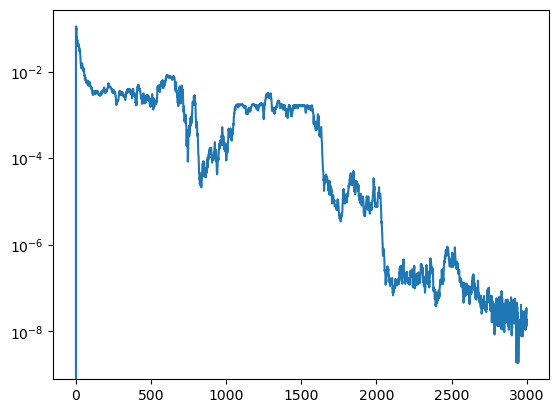

In [32]:
plt.plot(vmap(jnp.linalg.norm, 0)(result.cov_array)[0 : result.iteration])
plt.yscale("log")

In [33]:
all_f.est_mean(result.particles_locations, result.weights)

Array([ 0.26138106,  0.33054966,  0.0661549 , -0.33640525], dtype=float32)

In [34]:
true_pars

Array([ 0.314216,  0.35833 ,  0.053851, -0.333695], dtype=float32)

# OLD CODE WITHOUT ENCAPSULATION

In [201]:
for _ in range(200):
    iter = iter + 1
    print(f"Iteration number: {iter}")
    key, subkey = jax.random.split(key)
    t = jax.random.uniform(key=subkey, minval=0.01, maxval=40)

    keys = jax.random.split(key, number_of_experimental_repetitions + 1)

    key = keys[0]

    results = jax.vmap(model.generate_data, in_axes=(0, None, None))(
        keys[1:], game.true_pars, t
    )

    all_lkls = jax.vmap(model.likelihood_particle, in_axes=(0, None))(
        particles_locations, t
    )

    lkl_results_all_particles = vmap(game.likelihood_data, in_axes=(0, None))(
        all_lkls, results
    )

    lkl = jnp.prod(lkl_results_all_particles, axis=1)

    weights = all_f.update_weights(lkl, weights)
    cov_list.append(all_f.est_cov(particles_locations, weights))

    if all_f.ESS(weights) <= 0.5 * particles_locations.shape[1]:
        print("Resampling...")
        key, particles_locations, weights = all_f.resample_now(
            key, particles_locations, weights, a=0.98
        )

cov_arr = jnp.array(cov_list)

Iteration number: 2401
Iteration number: 2402
Iteration number: 2403
Iteration number: 2404
Iteration number: 2405
Iteration number: 2406
Iteration number: 2407
Iteration number: 2408
Iteration number: 2409
Iteration number: 2410
Iteration number: 2411
Iteration number: 2412
Iteration number: 2413
Iteration number: 2414
Iteration number: 2415
Iteration number: 2416
Iteration number: 2417
Iteration number: 2418
Iteration number: 2419
Iteration number: 2420
Iteration number: 2421
Iteration number: 2422
Iteration number: 2423
Iteration number: 2424
Iteration number: 2425
Iteration number: 2426
Iteration number: 2427
Iteration number: 2428
Iteration number: 2429
Iteration number: 2430
Iteration number: 2431
Iteration number: 2432
Iteration number: 2433
Iteration number: 2434
Iteration number: 2435
Iteration number: 2436
Iteration number: 2437
Iteration number: 2438
Iteration number: 2439
Iteration number: 2440
Iteration number: 2441
Iteration number: 2442
Iteration number: 2443
Iteration n

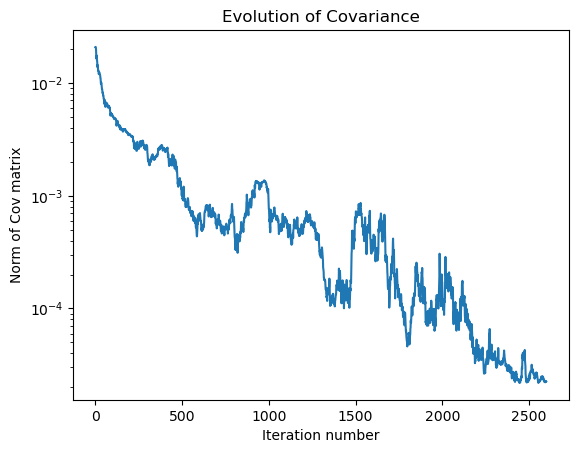

In [202]:
plt.title("Evolution of Covariance")
plt.plot(jax.vmap(jnp.linalg.norm, in_axes=(0))(cov_arr))
plt.xlabel("Iteration number")
plt.ylabel("Norm of Cov matrix")
plt.yscale("log")
plt.show()

In [203]:
true_pars

Array([ 0.314216,  0.35833 ,  0.053851, -0.333695], dtype=float32)

In [204]:
all_f.est_mean(particles_locations, weights).T

Array([ 0.28590244,  0.35768318,  0.05030785, -0.3457864 ], dtype=float32)

In [680]:
all_f.est_cov(particles_locations, weights)

Array([[ 7.4008854e-06,  5.5455712e-06,  1.2450771e-06, -6.3996725e-07],
       [ 5.5455712e-06,  1.8714632e-05,  1.1610365e-06,  2.8287798e-07],
       [ 1.2450771e-06,  1.1610365e-06,  2.8552499e-06,  2.3756895e-06],
       [-6.3996725e-07,  2.8287798e-07,  2.3756895e-06,  3.6203351e-06]],      dtype=float32)